### Project: Customer Segmentation

#### The Goal is to find right customers for the right marketing campaign. This can be achieved by finding insights using customer behaviour and their characteristics, grouping them together into different segments and finally specific marketing campaign can be targetted for each segment.

#### This is an Unsupervised Learning problem statement
Dataset used is available along with its details at https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df_data = pd.read_csv('Mall_Customers.csv')
df_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Perform basic EDA

In [3]:
df_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

#### Observation:
No null values

In [6]:
df_data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


#### Observation:
CustomerID is similar to index and not giving any extra information, it can be dropped

In [7]:
df_data.drop('CustomerID', axis=1, inplace=True)
df_data

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [8]:
# Renaming the columns to make it easy to use
df_data.rename(columns={'Annual Income (k$)':'AnnualIncome','Spending Score (1-100)':'SpendingScore'}, inplace=True)

#### Plot all features and see the distribution of customers

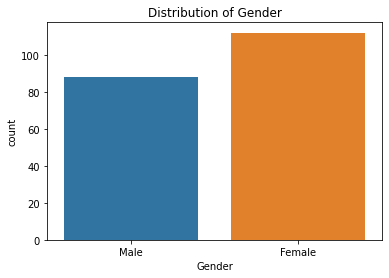

In [9]:
sns.countplot(x='Gender', data=df_data)
plt.title('Distribution of Gender')
plt.show()

#### Observation:
There are more Female customers than Male Customers in the dataset, but it is not imbalanced.

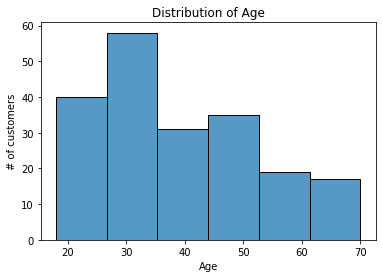

In [10]:
sns.histplot(x='Age', data=df_data, bins=6)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('# of customers')
plt.show()

#### Observation:
Maximum Customers belong to the Age Group 26-35

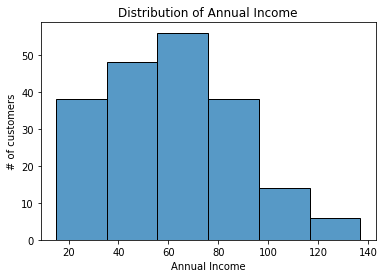

In [11]:
sns.histplot(x='AnnualIncome', data=df_data, bins=6)
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('# of customers')
plt.show()

#### Observation:
Maximum Customers have annual income between 55k to 75k$

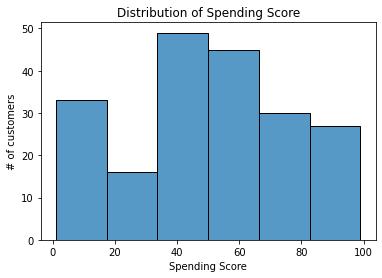

In [12]:
sns.histplot(x='SpendingScore', data=df_data,bins=6)
plt.title('Distribution of Spending Score')
plt.xlabel('Spending Score')
plt.ylabel('# of customers')
plt.show()

#### Observation:
Maximum Customers have a spending score around 35-65

#### Look for pair wise relationships

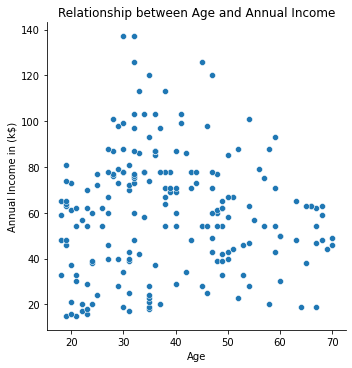

In [13]:
sns.relplot(x='Age', y='AnnualIncome', data=df_data)
plt.title('Relationship between Age and Annual Income')
plt.xlabel('Age')
plt.ylabel('Annual Income in (k$)')
plt.show()

#### Observation:
Data points are distributed with no concentrated regions

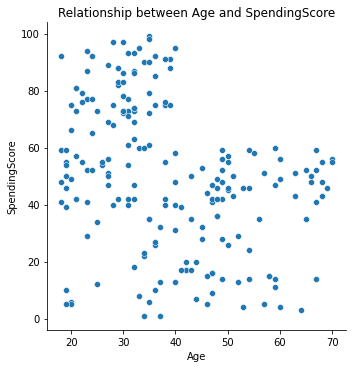

In [14]:
sns.relplot(x='Age', y='SpendingScore', data=df_data)
plt.title('Relationship between Age and SpendingScore')
plt.xlabel('Age')
plt.ylabel('SpendingScore')
plt.show()

#### Observation:
Some concentraion of data points is seen with people <40 year having higher Spending score

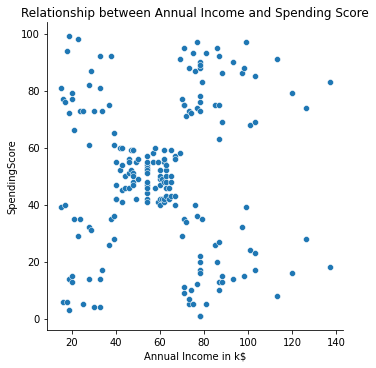

In [15]:
sns.relplot(x='AnnualIncome', y='SpendingScore', data=df_data)
plt.title('Relationship between Annual Income and Spending Score')
plt.xlabel('Annual Income in k$')
plt.ylabel('SpendingScore')
plt.show()

#### Observation:
Clusters can be seen to form in this relationship. 5 clusters seem to exists.

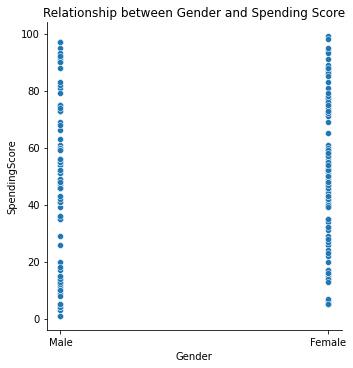

In [16]:
sns.relplot(x='Gender', y='SpendingScore', data=df_data)
plt.title('Relationship between Gender and Spending Score')
plt.xlabel('Gender')
plt.ylabel('SpendingScore')
plt.show()

#### Observation:
No clear clusters are seen with gender feature.

### Using Unsupervised Learning
Based on the above plots there seems to be clusters with Age and SpendingScore and with SpendingScore and AnnualIncome.

Try performing k-Means clustering for both and see the results.

Metric to be used: wcss (Within cluster Sum of Squared distance)

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [18]:
# Convert Gender into numeric data
df_data = pd.get_dummies(df_data, columns=['Gender'], drop_first=True)

In [19]:
# Split 70% of the data into train set
X_train = df_data.sample(frac=0.7, random_state=1)
X_train.shape

(140, 4)

In [20]:
# Split the remianing 30% data into test set
X_test = df_data.drop(X_train.index, axis=0)

# reset the index
X_test.reset_index(inplace=True)
X_train.reset_index(inplace=True)

# resetting creates a new columns called index, drop it
X_train.drop('index',axis=1, inplace=True)
X_test.drop('index',axis=1, inplace=True)

In [21]:
X_train

,Age,AnnualIncome,SpendingScore,Gender_Male
0,27,46,51,0
1,65,38,35,0
2,49,33,14,0
3,67,62,59,1
4,41,99,39,0
...,...,...,...,...
135,31,25,73,1
136,43,71,35,1
137,30,19,72,0
138,40,87,13,1


1) Age and SpendingScore as X

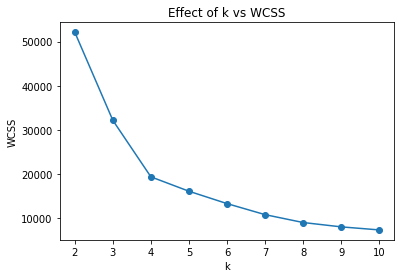

In [22]:
X_1=X_train[['Age','SpendingScore']]

X_2=X_test[['Age','SpendingScore']]
# finding the right value of k, using elbow curve
wcss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_1)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,11), wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Effect of k vs WCSS')
plt.show()

#### Observation:
k value of 4,5 is where we see the elbow forming.
Lets try with 5 clusters

In [23]:
kmeans = KMeans(n_clusters=5, random_state=1)
y_1 = kmeans.fit_predict(X_1)
y_2 = kmeans.predict(X_2)
cluster_centroids = kmeans.cluster_centers_
print(cluster_centroids)

[[56.34375    48.1875    ]
 [31.84210526 90.78947368]
 [42.5625     15.84375   ]
 [28.73076923 70.69230769]
 [28.12903226 45.        ]]


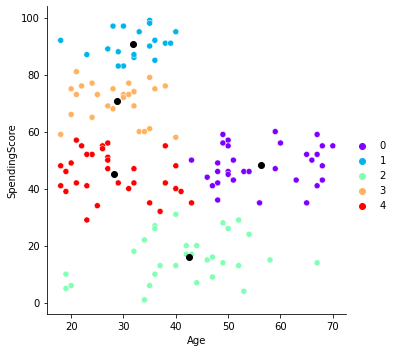

In [24]:
sns.relplot(x='Age',y='SpendingScore',hue=y_1, palette='rainbow', data=X_1)
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

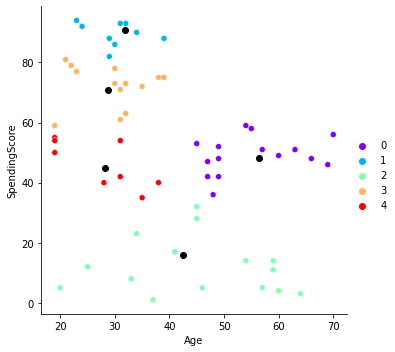

In [25]:
sns.relplot(x='Age',y='SpendingScore',hue=y_2, palette='rainbow', data=X_2)
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

#### Observation
Looks like the cluster with label of 4 is too broad. If we would have tried with 4 clusters the distribution would be even more poor.

2) AnnualIncome and SpendingScore as X

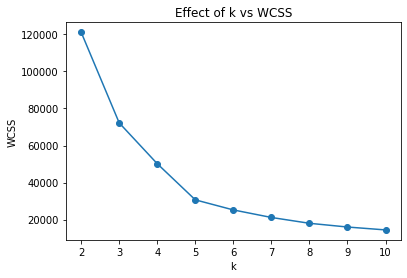

In [26]:
X_1=X_train[['AnnualIncome','SpendingScore']]

X_2=X_test[['AnnualIncome','SpendingScore']]
# finding the right value of k, using elbow curve
wcss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_1)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,11), wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Effect of k vs WCSS')
plt.show()


#### Observation:
k value of 5 is where we see the elbow forming.
So k=5

In [27]:
kmeans = KMeans(n_clusters=5, random_state=1)
y_1 = kmeans.fit_predict(X_1)
y_2 = kmeans.predict(X_2)
cluster_centroids = kmeans.cluster_centers_
print(cluster_centroids)

[[55.96491228 49.47368421]
 [86.8        18.92      ]
 [91.38461538 83.        ]
 [26.52941176 22.82352941]
 [26.46666667 77.86666667]]


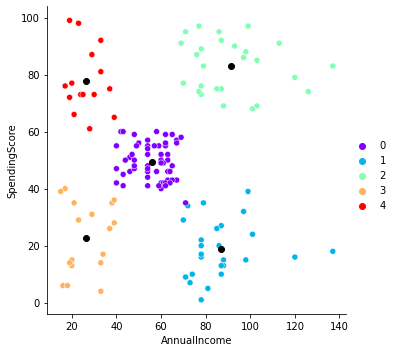

In [28]:
sns.relplot(x='AnnualIncome',y='SpendingScore',hue=y_1, palette='rainbow', data=X_1)
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

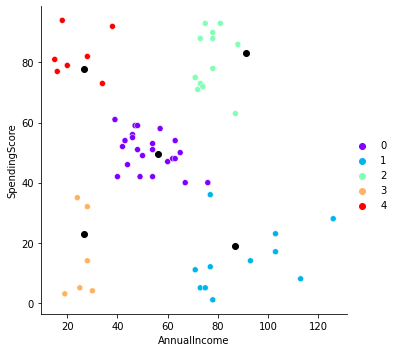

In [29]:
sns.relplot(x='AnnualIncome',y='SpendingScore',hue=y_2, palette='rainbow', data=X_2)
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

### Observation:
Based on the two cluster plots the clusters formed using AnnualIncome and SpendingScore as input features has well formed clusters. 

#### Lets try scaling the data as distances will get impacted by values

In [30]:
scaler = StandardScaler()

In [31]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # using only transform for test set to avoid data leakage

In [32]:
X_train_scaled

array([[-8.33137769e-01, -5.73725216e-01,  3.79482846e-02,
        -8.66025404e-01],
       [ 1.92155019e+00, -8.73432418e-01, -6.01180720e-01,
        -8.66025404e-01],
       [ 7.61681578e-01, -1.06074942e+00, -1.44003754e+00,
        -8.66025404e-01],
       [ 2.06653377e+00,  2.56891888e-02,  3.57512787e-01,
         1.15470054e+00],
       [ 1.81747270e-01,  1.41183500e+00, -4.41398468e-01,
        -8.66025404e-01],
       [-4.70678827e-01,  2.83544421e+00, -1.28025529e+00,
         1.15470054e+00],
       [-1.05061313e+00, -4.92376118e-02,  7.78938474e-02,
         1.15470054e+00],
       [-5.43170615e-01, -1.66016382e+00, -4.01452906e-01,
        -8.66025404e-01],
       [-1.12310492e+00, -1.21060302e+00,  1.47598854e+00,
        -8.66025404e-01],
       [-1.80711673e-01,  9.62274196e-01, -9.20745222e-01,
        -8.66025404e-01],
       [-7.60645981e-01,  9.62274196e-01,  9.96641791e-01,
         1.15470054e+00],
       [ 9.79156943e-01, -1.43538342e+00, -8.40854096e-01,
      

### Lets apply KMeans using all the features

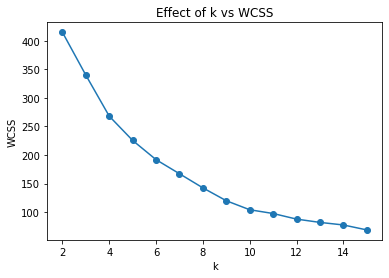

In [33]:
# finding the right value of k, using elbow curve
wcss = []
for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_train_scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,16), wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Effect of k vs WCSS')
plt.show()


#### Observation:
No clear elbow is formed. Previous cases were better.

### Lets try scaling only on selected features

1) Age and SpendingScore as X

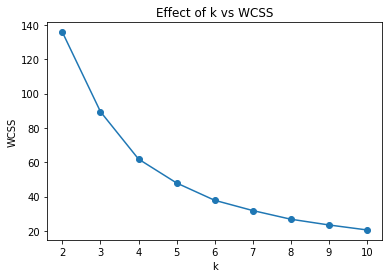

In [34]:
X_1=X_train[['Age','SpendingScore']]
X_1_scaled = scaler.fit_transform(X_1)

X_2=X_test[['Age','SpendingScore']]
X_2_scaled = scaler.transform(X_2)
# finding the right value of k, using elbow curve
wcss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_1_scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,11), wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Effect of k vs WCSS')
plt.show()

#### Observation:
k value of 4,5 is where we see the elbow forming.
Lets try with 5 clusters

In [35]:
kmeans = KMeans(n_clusters=5, random_state=1)
y_1 = kmeans.fit_predict(X_1_scaled)
y_2 = kmeans.predict(X_2_scaled)
cluster_centroids = kmeans.cluster_centers_
print(cluster_centroids)

[[-0.60891898  1.2019434 ]
 [ 0.57743162 -0.12183397]
 [ 1.89889651 -0.13931015]
 [-1.05320213 -0.31014876]
 [ 0.3942232  -1.30504908]]


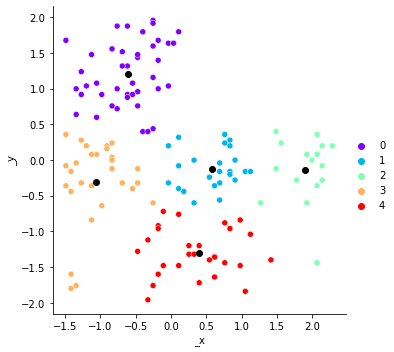

In [36]:
sns.relplot(x=X_1_scaled[:,0],y=X_1_scaled[:,1],hue=y_1, palette='rainbow')
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

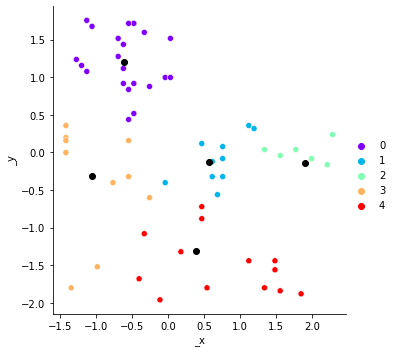

In [37]:
sns.relplot(x=X_2_scaled[:,0],y=X_2_scaled[:,1],hue=y_2, palette='rainbow')
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

#### Observation
Looks like the clusters on the lower left and mid bottom too broad. The points in the lower left are very far away from any cluster. To accomodate them properly we need a lot of clusters.

2) AnnualIncome and SpendingScore as X

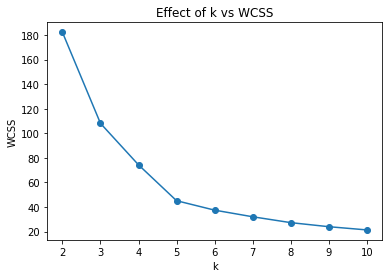

In [38]:
X_1=X_train[['AnnualIncome','SpendingScore']]
X_1_scaled = scaler.fit_transform(X_1)

X_2=X_test[['AnnualIncome','SpendingScore']]
X_2_scaled = scaler.transform(X_2)
# finding the right value of k, using elbow curve
wcss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_1_scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,11), wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Effect of k vs WCSS')
plt.show()


#### Observation:
k value of 5 is where we see the elbow forming clearly.
So k=5

In [39]:
kmeans = KMeans(n_clusters=5, random_state=1)
y_1 = kmeans.fit_predict(X_1_scaled)
y_2 = kmeans.predict(X_2_scaled)
cluster_centroids = kmeans.cluster_centers_
print(cluster_centroids)

[[-0.20040572 -0.02302126]
 [ 0.95478152 -1.24350537]
 [ 1.1265368   1.31620629]
 [-1.30315966 -1.08757669]
 [-1.3055103   1.1111524 ]]


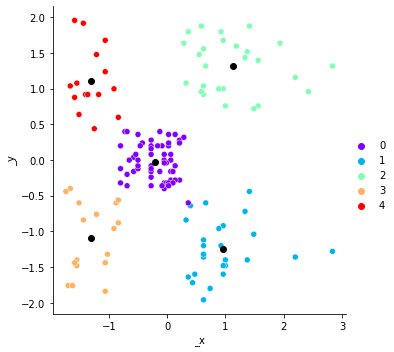

In [40]:
sns.relplot(x=X_1_scaled[:,0],y=X_1_scaled[:,1],hue=y_1, palette='rainbow')
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

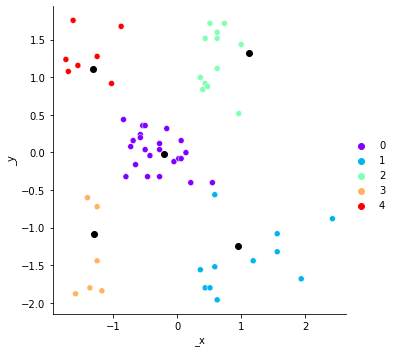

In [41]:
sns.relplot(x=X_2_scaled[:,0],y=X_2_scaled[:,1],hue=y_2, palette='rainbow')
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

### Observation:
Clusters are well formed for both the train data and test data, with data points being reasonably closer to their centroids.

The behaviour without scaling and with scaling is very similar. In this case there was not much influnce of the scaling.

Lets have a look at the one without scaling as it is bit more interpretable and can be used readily when deployed in a flask app.

In [42]:
X_1=X_train[['AnnualIncome','SpendingScore']]
X_2=X_test[['AnnualIncome','SpendingScore']]

In [43]:
kmeans = KMeans(n_clusters=5, random_state=1)
y_1 = kmeans.fit_predict(X_1)
y_2 = kmeans.predict(X_2)
cluster_centroids = kmeans.cluster_centers_
print(cluster_centroids)

[[55.96491228 49.47368421]
 [86.8        18.92      ]
 [91.38461538 83.        ]
 [26.52941176 22.82352941]
 [26.46666667 77.86666667]]


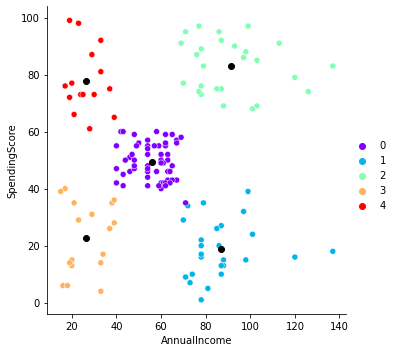

In [44]:
plt.show()
sns.relplot(x='AnnualIncome',y='SpendingScore',hue=y_1, palette='rainbow', data=X_1)
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

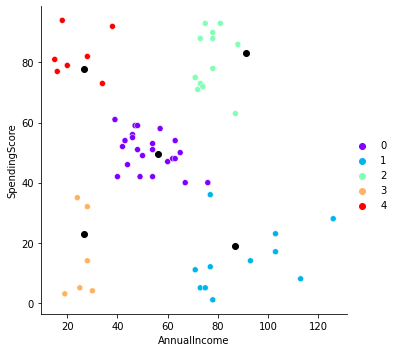

In [45]:
sns.relplot(x='AnnualIncome',y='SpendingScore',hue=y_2, palette='rainbow', data=X_2)
plt.scatter(cluster_centroids[:,0],cluster_centroids[:,1], color='black')
plt.show()

### Conclusion:
Based on the clusters formed using Annual Income and Spending Score assigned it is now possible to segement the customers into different categories which can then be used for marketing campaigns or special discounts, etc depending on the business need.

The clusters can be interpreted as follows:

| Cluster Number | Annual Income (k$)| Spending Score | Category Description | Targeted Marketing Campaign |
| --- | --- | --- | --- | --- |
| 0 | 40-75 | 40-60 | Mid Income Mid Frequent Shoppers | Inform them of both clearence sale and seasonal sales on medium price range items |
| 1 | >70 | 0-40 | High Income NonFrequent Shoppers | Not loyal customers with disposable income, try selling expensive items or limited collections as they are likely to make 1 time purchases |
| 2 | >70 | 60-100 | High Income Frequent Shoppers | Loyal customers with disposable income, try to sell expensive items without any discount |
| 3 | 15-40 | 0-40 | Low Income NonFrequent Shoppers | Seasonal sale discount on cheaper items |
| 4 | 15-40 | 60-100 | Low Income Frequent Shoppers | Clearence sale discount on cheaper items at any time |

### Save the model, to be used in Flask

In [46]:
joblib.dump(kmeans,'model.pkl')

['model.pkl']

In [47]:
kmeans_saved = joblib.load('model.pkl')

In [48]:
print(kmeans_saved.predict([[50,40]])[0])
print(kmeans_saved.predict([[75,30]])[0])
print(kmeans_saved.predict([[75,80]])[0])
print(kmeans_saved.predict([[20,30]])[0])
print(kmeans_saved.predict([[35,80]])[0])

0
1
2
3
4


C:\Users\Padmakar\anaconda3\envs\CustomerSegmentation\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Padmakar\anaconda3\envs\CustomerSegmentation\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Padmakar\anaconda3\envs\CustomerSegmentation\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Padmakar\anaconda3\envs\CustomerSegmentation\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Padmakar\anaconda3\envs\CustomerSegmentation\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.w